In [1]:
import torchvision
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from mydataset import SinusoidalDataset, regression_acc, Sinusoid
import copy
acc = regression_acc

In [2]:
bsize_outer = 16
bsize_inner = 20
dataset = SinusoidalDataset(bsize_outer=bsize_outer, bsize_inner=bsize_inner)
loader = torch.utils.data.DataLoader(dataset, batch_size=None, num_workers=0, batch_sampler=None)

In [3]:
class Model(nn.Module):
    def __init__(self, net_arch):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(a, b) for a, b in zip(net_arch[:-1], net_arch[1:])])
    def forward(self, x):
        h = torch.tensor(x, dtype=torch.float)
        for lay in self.layers[:-1]:
            h = F.relu(lay(h))
        h = self.layers[-1](h)
        return h
model = Model([1, 128, 128, 1])
model(xexamples)[0, :10]

NameError: name 'xexamples' is not defined

In [4]:
opt_outer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [5]:
def mymaml_grad(model, intrain, targtrain, intest, targtest, lr):
    params = list(model.parameters())
    return_grads = None
    batch_size = len(intrain)
    cumloss = 0
    cumacc = 0
    preds = 0

    for x_train, y_train, x_test, y_test in zip(intrain, targtrain, intest, targtest):

        model1 = copy.deepcopy(model)
        preds = model1(x_train)
        # loss1 = -(y_train*torch.log(preds+1e-8)).mean()
        loss1 = ((y_train-preds)**2).mean()
        loss1.backward(create_graph=True, retain_graph=True)

        model2 = copy.deepcopy(model)
        news = []
        for param1, param2 in zip(model1.parameters(), model2.parameters()):
            tmp = param1 - lr*param1.grad 
            param2.data.copy_(tmp)
            news.append(tmp)

        preds = model2(x_test)
        #loss1 = -(y_test*torch.log(preds+1e-8)).mean()
        loss = ((y_test-preds)**2).mean()/batch_size
        cumacc += acc(y_test, preds)
        cumloss += loss.item()
        grads1 = torch.autograd.grad(loss, list(model2.parameters()))
        grads2 = torch.autograd.grad(news, list(model1.parameters()), grad_outputs=grads1)

        if return_grads is None:
            return_grads = list(grads2)
        else:
            for i, g2 in enumerate(grads2):        torch.nn.LeakyReLU(),
                return_grads[i] += g2
    for p, g in zip(model.parameters(), return_grads):
        with torch.no_grad():
            if p.grad is None:
                p.grad = g
                continue
            p.grad += g
    return cumloss, cumacc/batch_size, preds

In [91]:
eps=1000
ii = 0
writer = SummaryWriter('tb/reptile_regression_sinus_nomulti_dim=0_')
for ep in range(eps):
    for step, (x, y) in enumerate(loader):
        xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
        yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)
        # print(xexamples.shape, xtoguess.shape, yexamples.shape, ytoguess.shape, x.shape, y.shape)
        
        opt_outer.zero_grad()
        # loss, accuraccy, _ = mymaml_grad(model, xexamples, yexamples, xtoguess, ytoguess, 0.1)
        print(model(xexamples)[0, :10])
        loss, accuraccy, _ = reptile_optimize(model, xexamples, yexamples, xexamples, yexamples, 1e-3, 5, 0.97)
        print(model(xexamples)[0, :10], _[0, :10])
        print("-"*20)
        opt_outer.step()
        writer.add_scalar('metric/loss', loss, ii := ii+1)
        writer.add_scalar('metric/accu', accuraccy, ii)

        import time 
        # time.sleep(5) 
        print(ep, step, loss, accuraccy)

tensor([[0.2538],
        [0.2402],
        [0.2245],
        [0.2572],
        [0.2498],
        [0.1733],
        [0.1674],
        [0.2297],
        [0.2229],
        [0.2487]], grad_fn=<SliceBackward>)
tensor([[0.3039],
        [0.2863],
        [0.2660],
        [0.3083],
        [0.2987],
        [0.2000],
        [0.1920],
        [0.2727],
        [0.2638],
        [0.2973]], grad_fn=<SliceBackward>) tensor([0.1738], grad_fn=<SliceBackward>)
--------------------
0 0 11.550632569938898 11.664539888501167
tensor([[0.2081],
        [0.2012],
        [0.2907],
        [0.2499],
        [0.2676],
        [0.2397],
        [0.2711],
        [0.2556],
        [0.2632],
        [0.2298]], grad_fn=<SliceBackward>)
tensor([[0.2344],
        [0.2263],
        [0.3310],
        [0.2829],
        [0.3038],
        [0.2709],
        [0.3079],
        [0.2897],
        [0.2986],
        [0.2598]], grad_fn=<SliceBackward>) tensor([2.3789], grad_fn=<SliceBackward>)
--------------------
0 1 19.8

KeyboardInterrupt: 

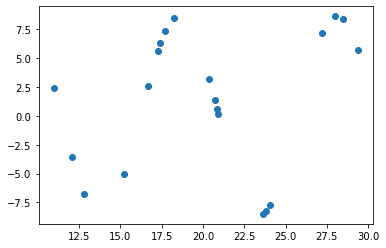

In [4]:
# idx = torch.argsort(a).squeeze(-1)
# a = a[idx]
# b = b[idx]
# plt.scatter(a.squeeze(-1).numpy(), b.squeeze(-1).numpy()), idx.shape
x, y = xexamples, yexamples = dataset[0]
plt.scatter(x[0].numpy(), y[0].numpy())

In [131]:
import numpy as np
dataset_test = SinusoidalDataset(bsize_outer=1, bsize_inner=1000)
x, y = Sinusoid(5, 2, 0).get_sample(1000)
xexamples, xtoguess = x[:, :900], x[:, -100:]
yexamples, ytoguess = y[:, :900], y[:, -100:]
# a, b, c = mymaml_grad(model, xexamples, yexamples, xtoguess, ytoguess, lr=0.5)
model = Model([1, 12, 1])
rez = model(xexamples)
print(rez[0, :10].t())
a, b, c = reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 0.5, 5, 1-1e-1, True)
rez = model(xexamples)
print(rez[0, :10].t())

tensor([[0.1655, 0.1498, 0.6485, 0.4126, 0.6707, 0.3267, 0.3602, 0.2178, 0.1877,
         0.1661]], grad_fn=<TBackward>)
tensor([[0.8366, 0.8073, 1.7417, 1.2997, 1.7833, 1.1387, 1.2015, 0.9345, 0.8782,
         0.8378]], grad_fn=<TBackward>)


In [9]:
preds0, y, x = model(xtoguess[0]).detach().numpy(), ytoguess.numpy()[0], xtoguess.numpy()[0]
perm = np.argsort(x, axis=0).squeeze(-1)
# _, _, preds1 = mymaml_grad(model, xexamples, yexamples, xtoguess, ytoguess, 0.1)
_, _, preds1 = reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 0.01, 5, 0.9, update_model=False)
preds1 = preds1.detach().numpy()
preds0, preds1, x, y = preds0[perm], preds1[perm], x[perm], y[perm]
plt.plot(x, y, 'r', x, preds0, 'g', x, preds1, 'b');
preds1[perm][:20]

NameError: name 'xtoguess' is not defined

In [149]:
def reptile_optimize(model, intrain, targtrain, intest, targtest, lr, n, alfa=0.95, update_model=True):
    cumloss, cummacc = 0, 0
    preds = 0
    for x_train, y_train, x_test, y_test in zip(intrain, targtrain, intest, targtest):
        model_copy = copy.deepcopy(model)
        model_copy = model
        opt = torch.optim.Adam(model_copy.parameters(), lr=lr)
        for i in range(n):
            preds = model_copy(x_train)
            # loss = -(y_train*torch.log(preds+1e-8)).mean()
            loss = ((y_train-preds)**2).mean()
            print(preds.shape, x_train.shape)
            cumloss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        if update_model:
            polyak(model_copy, model, alfa=alfa)
        preds = model_copy(x_test)
        cummacc += acc(y_test, preds)
    print("-"*10)
    return cumloss/intrain.shape[0]/n, cummacc/intrain.shape[0], preds


def polyak(a, b, alfa=0.99):
    for namea, parama in a.named_parameters():
        for nameb, paramb in b.named_parameters():
            if namea == nameb:
                paramb.data = paramb.data*alfa + parama.data*(1-alfa)
    return b 

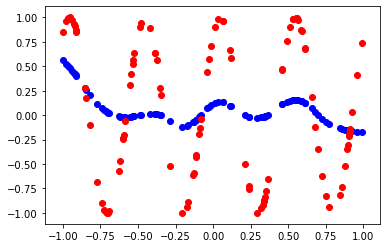

In [161]:
# x = torch.randn(1, 40, 1)
# y = torch.randn(1, 40, 1)
# y = 2*x**2+ 3*x + 1 +x**3
x, y = Sinusoid(1, 0.5, 1).get_sample(100, minx=-1, maxx=1)
x.squeeze_(0)
y.squeeze_(0)
model = Model([1, 256, 32, 1])
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(100):
    loss = ((y - model(x))**2).mean()
    opt.zero_grad()
    loss.backward()
    if i % 99 == -1:
        print((str(i)+" ")*10)
        for n, p in model.named_parameters():
            print(n, p.grad)
    opt.step()
    # print(loss.item())
# model(x)[:10].t(), y[:10].t(), x[:10].t(), x.shape, y.shape, model(x).shape
plt.scatter(x.numpy(), model(x).detach().numpy(), c='b')
plt.scatter(x.numpy(), y.numpy(), c='r')
plt.show()
# y, model(x)

In [99]:
model(torch.tensor([[1.0-2]]))

tensor([[5.4166]], grad_fn=<AddmmBackward>)

In [104]:
model.layers[-1].bias

Parameter containing:
tensor([0.7910], requires_grad=True)

In [105]:
class Model(nn.Module):
    def __init__(self, net_arch):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(a, b) for a, b in zip(net_arch[:-1], net_arch[1:])])
    def forward(self, h):
        for lay in self.layers[:-1]:
            h = F.tanh(lay(h))
        h = self.layers[-1](h)
        return h